In [2]:
!pip install import-ipynb


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Data reshaping for LSTM completed!
X_seq shape: (1951, 50, 5)
Y_seq shape: (1951, 1)
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Predictions completed!


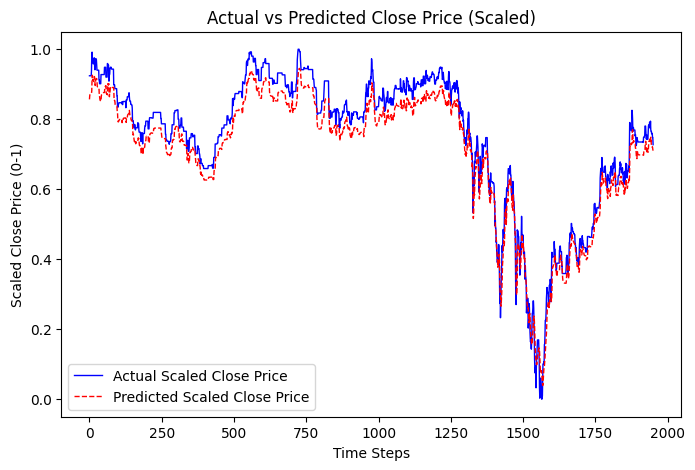

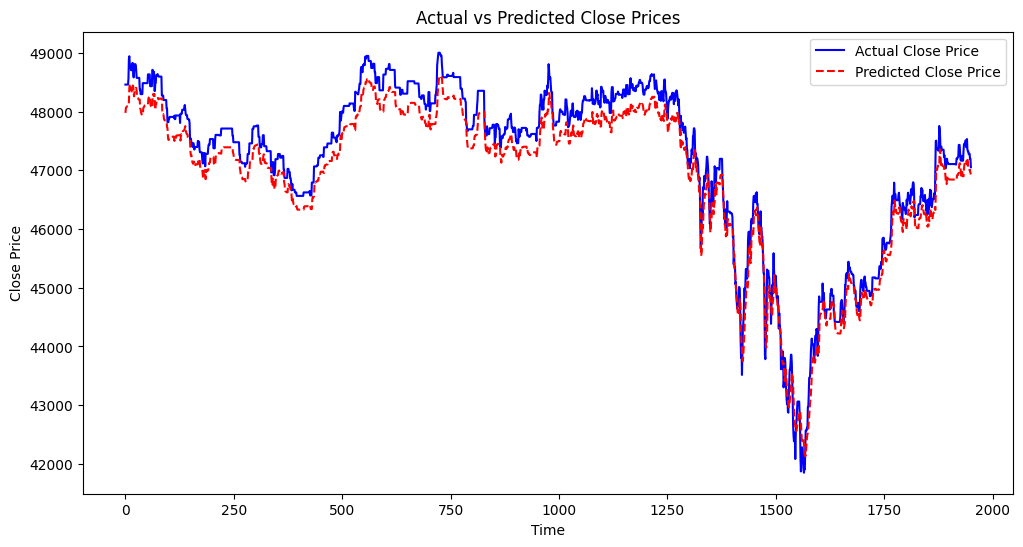

 Model Evaluation Metrics:
 MAE  : 307.2999
 RMSE : 329.4235
 R²   : 0.9469
 MAPE : 0.65%


In [3]:
import import_ipynb
import test_model
import numpy as np
import matplotlib.pyplot as plt

In [4]:
actual_prices = test_model.actual_prices
test_prediction_prices = test_model.test_prediction_prices

### Backtesting

In [5]:
def backtest_with_moving_avg(actual_prices, predicted_prices, window, initial_cash):
    cash = initial_cash
    btc = 0
    portfolio_values = []
    actions = []

    # Calculate moving average of predictions
    ma_pred = np.convolve(predicted_prices, np.ones(window)/window, mode='same')

    for i in range(1, len(predicted_prices)):
        price = actual_prices[i]

        # Entry/Exit signals based on crossover
        if predicted_prices[i-1] < ma_pred[i-1] and predicted_prices[i] > ma_pred[i]:
            # Crossed above → Buy
            if cash > 0:
                btc = cash / price
                cash = 0
                actions.append("BUY")
            else:
                actions.append("HOLD")
        elif predicted_prices[i-1] > ma_pred[i-1] and predicted_prices[i] < ma_pred[i]:
            # Crossed below → Sell
            if btc > 0:
                cash = btc * price
                btc = 0
                actions.append("SELL")
            else:
                actions.append("HOLD")
        else:
            actions.append("HOLD")

        # Track portfolio
        portfolio_value = cash + btc * price
        portfolio_values.append(portfolio_value)
    return portfolio_values, actions


In [10]:
# Run the backtest
initial_cash = 10000 
portfolio_values, actions = backtest_with_moving_avg(actual_prices, test_prediction_prices, 3, initial_cash)

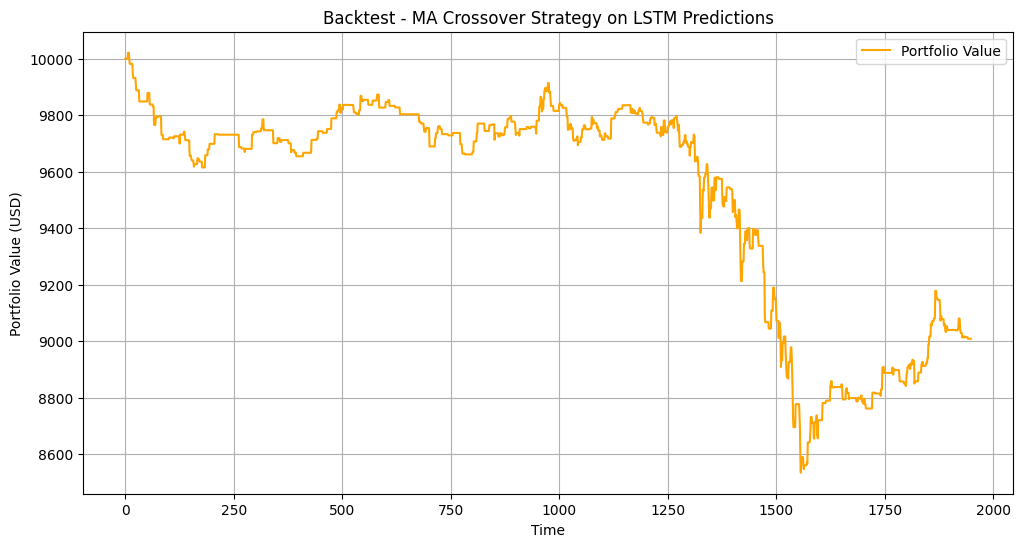

In [11]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Portfolio Value", color="orange")
plt.title("Backtest - MA Crossover Strategy on LSTM Predictions")
plt.xlabel("Time")
plt.ylabel("Portfolio Value (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Risk metrics

In [8]:
returns = np.diff(portfolio_values) / portfolio_values[:-1]
volatility = np.std(returns)
sharpe = np.mean(returns) / volatility if volatility != 0 else 0
max_drawdown = np.max(np.maximum.accumulate(portfolio_values) - portfolio_values)

# Output
print(f"Moving Average Crossover Strategy")
print(f"Final Portfolio Value: ${portfolio_values[-1]:.2f}")
print(f"Total Return: {((portfolio_values[-1] / initial_cash - 1) * 100):.2f}%")
print(f"Volatility: {volatility:.4f}")
print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Max Drawdown: ${max_drawdown:.2f}")

Moving Average Crossover Strategy
Final Portfolio Value: $10118.27
Total Return: 1.18%
Volatility: 0.0016
Sharpe Ratio: 0.0046
Max Drawdown: $772.82
